In [74]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import re
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML
import seaborn as sns
import urllib.request as urllib2
from bs4 import BeautifulSoup

## Data Cleaning

In [11]:
data = pd.read_csv("data.csv")

In [51]:
# train/valid/test = 0.8/0.1/0.1

def clean_text(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return cleaned_text.lower()
    
def clean_instances(data):
    instances = data["sentence"]
    labels = data["is_instance"]
    
    labels = ["instance" if l else "not_instance" for l in labels]
    
    cleaned_instances = [clean_text(inst) for inst in instances]
    
    df_new = pd.DataFrame(columns = data.columns)
    df_new[data.columns] = data[data.columns]
    df_new["sentence"] = cleaned_instances
    
    df_new["is_instance"] = labels
    
    return df_new


data_clean = clean_instances(data)

train_text, truth_text, train_labels, truth_labels = train_test_split(data_clean["sentence"], data_clean["is_instance"], test_size = 0.1, shuffle = True)
train_text, test_text, train_labels, test_labels = train_test_split(train_text, train_labels, test_size = 1/9, shuffle = True)

train_text, test_text, truth_text = train_text.to_numpy(), test_text.to_numpy(), truth_text.to_numpy()
train_labels, test_labels, truth_labels = train_labels.to_numpy(), test_labels.to_numpy(), truth_labels.to_numpy()

In [52]:
fasttext_data_train = [f"__label__{train_labels[i]} {train_text[i]}" for i in range(len(train_labels))]
fasttext_data_test = [f"__label__{test_labels[i]} {test_text[i]}" for i in range(len(test_labels))]
fasttext_data_truth = [f"__label__{truth_labels[i]} {truth_text[i]}" for i in range(len(truth_labels))]

train_file = open("model.train", "w+")
test_file = open("model.valid", "w+")
truth_file = open("model.truth", "w+")

train_file.write("\n".join(fasttext_data_train))
test_file.write("\n".join(fasttext_data_test))
truth_file.write("\n".join(fasttext_data_truth))

train_file.close()
test_file.close()
truth_file.close()

## Parameter Selection

In [53]:
cv_data = []

for lr in np.arange(0, 1, 0.05):
    row = []
    for epochs in range(5, 35, 5):
        model_cv = fasttext.train_supervised(input = "model.train", lr = lr, epoch = epochs)
        p = model_cv.test("model.valid")[1]
        row.append(p)
    cv_data.append(row)

<AxesSubplot:>

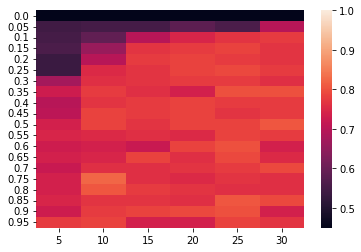

In [54]:
sns.heatmap(cv_data, vmin = np.min(cv_data), vmax = 1, xticklabels = np.arange(5, 35, 5), yticklabels = np.arange(0, 1, 0.05).round(3))

In [55]:
max_idx = np.unravel_index(np.array(cv_data).argmax(), np.array(cv_data).shape)
best_learning_rate = np.arange(0, 1, 0.05)[max_idx[0]]
best_epochs = np.arange(5, 35, 5)[max_idx[1]]
max_p = cv_data[max_idx[0]][max_idx[1]]

print(f"Best Learning Rate: {best_learning_rate}\nBest Number of Epochs: {best_epochs}\nMax Precision/Recall: {max_p}")

Best Learning Rate: 0.75
Best Number of Epochs: 10
Max Precision/Recall: 0.8217054263565892


In [60]:
def create_confusion_mat(text, labels, m):
    
    df = pd.DataFrame(confusion_matrix([str(l) for l in labels], [m.predict(t)[0][0][len("__label__"):] for t in text]), index = ["Actual Not Instance", "Actual Instance"])
    df.columns = ["Predicted Not Instance", "Predicted Instance"]
                  
    return df

def print_precision_recall(filename, m):
    n, p, r = m.test(filename)
    print(f"Results for {filename}\nPrecision: {p} | Recall: {p}\n\n")

## Analyzing Results

In [57]:
model_cv = fasttext.train_supervised(input = "model.train", lr = best_learning_rate, epoch = best_epochs)

In [58]:
for fn in ["model.train", "model.valid", "model.truth"]:
    print_precision_recall(fn, model_cv)

Results for model.train
Precision: 0.9941860465116279 | Recall: 0.9941860465116279


Results for model.valid
Precision: 0.8062015503875969 | Recall: 0.8062015503875969


Results for model.truth
Precision: 0.7286821705426356 | Recall: 0.7286821705426356




In [61]:
display(HTML('<b>Training Data Confusion Matrix</b>'))
create_confusion_mat(train_text, train_labels, model_cv)

,Predicted Not Instance,Predicted Instance
Actual Not Instance,550,2
Actual Instance,4,476


In [63]:
display(HTML('<b>Validation Data Confusion Matrix</b>'))
create_confusion_mat(test_text, test_labels, model_cv)

,Predicted Not Instance,Predicted Instance
Actual Not Instance,60,11
Actual Instance,14,44


In [65]:
display(HTML('<b>Testing Data Confusion Matrix</b>'))
create_confusion_mat(truth_text, truth_labels, model_cv)

,Predicted Not Instance,Predicted Instance
Actual Not Instance,46,13
Actual Instance,22,48


## Predicting on the Web

In [144]:
def answer(url, tol):
    
    hdr = {'User-Agent': 'Mozilla/5.0'}
    req = urllib2.Request(url, headers = hdr)
    page = urllib2.urlopen(req)
    soup = BeautifulSoup(page, "html.parser")
    
    paragraphs_web = soup.findAll("p")
    paragraphs_web = [p.text for p in paragraphs_web]
    
    response = []

    for p in paragraphs_web:
        sentences = [s for s in nltk.sent_tokenize(p)]
        sentences_cleaned = [clean_text(s) for s in sentences]

        pred = [(model_cv.predict(s)[0][0][len("__label__"):] == 'instance', model_cv.predict(s)[1][0]) for s in sentences_cleaned]
        labels = ["I" if label and score > tol else "N" for label, score in pred]
        
        chunk_idxs = [(m.start(0), m.end(0)) for m in re.finditer("III*", "".join(labels))]
        
        chunks = []
        for start, end in chunk_idxs:
            if start == end:
                continue
            chunks.append(sentences[start:end])
        
        if len(chunks) > 0:
            chunk_text = [" ".join(c) for c in chunks]
            response.append(" ".join(chunk_text))
    
        
    return "\n\n".join(response)

In [145]:
print(answer("https://www.dataversity.net/a-brief-history-of-machine-learning/", 0.98))

LEARN HOW TO BUILD A DATA LITERACY PROGRAM
Developing Data Literacy is key to becoming a data-driven organization – try our online courses to get started. Register Here

The model was created in 1949 by Donald Hebb in a book titled The Organization of Behavior (PDF). The book presents Hebb’s theories on neuron excitement and communication between neurons.

In the late 1970s and early 1980s, artificial intelligence research had focused on using logical, knowledge-based approaches rather than algorithms. Additionally, neural network research was abandoned by computer science and AI researchers.

The industry goal shifted from training for artificial intelligence to solving practical problems in terms of providing services. Its focus shifted from the approaches inherited from AI research to methods and tactics used in probability theory and statistics.

Then the data weights are “re-weighted.”
Input data that is misclassified gains a higher weight, while data classified
correctly loses we

In [146]:
print(answer("https://www.forbes.com/sites/bernardmarr/2016/02/19/a-short-history-of-machine-learning-every-manager-should-read/?sh=2474976115e7", 0.8))

It’s all well and good to ask if androids dream of electric sheep, but science fact has evolved to a point where it’s beginning to coincide with science fiction. No, we don’t have autonomous androids struggling with existential crises — yet — but we are getting ever closer to what people tend to call “artificial intelligence.”

Machine Learning is a sub-set of artificial intelligence where computer algorithms are used to autonomously learn from data and information. In machine learning computers don’t have to be explicitly programmed but can change and improve their algorithms by themselves.

1967 — The “nearest neighbor” algorithm was written, allowing computers to begin using very basic pattern recognition. This could be used to map a route for traveling salesmen, starting at a random city but ensuring they visit all cities during a short tour.

2016 – Google’s artificial intelligence algorithm beats a professional player at the Chinese board game Go, which is considered the world’s 

In [147]:
print(answer("https://concisesoftware.com/history-of-machine-learning/", 0.9))

A machine learning algorithm looks for patterns in data and analyzes the examples we feed it. On the basis of these examples, it generates insights that allow making smarter decisions.

In order to pass the test, the computer needs to be able to convince a human to believe that it’s another human. Apart from a computer program simulating a 13-year-old Ukrainian boy who is said to have passed the Turing test, there were no other successful attempts so far.

Today, the nearest neighbor algorithm called KNN is mostly used to classify a data point on the basis of how their neighbors are classified. KNN is used in retail applications that recognize patterns in credit card usage or for theft prevention when implemented in CCTV image recognition in retail stores.

2010 – this year saw the introduction of Microsoft Kinect that could track even 20 human features at the rate of 30 times per second. Microsoft Kinect allowed users to interact with machines via gestures and movements.

Go is consid